## DEMO: H wavefunctions

#### Requirements | Importing libraries

In [24]:
import matplotlib, matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy, scipy.special as sp
from scipy.constants import physical_constants
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

try:
    from google.colab import output
    output.enable_custom_widget_manager()
    print('All good to go')
except:
    print('Okay we are not in Colab just proceed as if nothing happened')

Okay we are not in Colab just proceed as if nothing happened


#### 1. Describing a radial function $R_{nl}(r)$

$$R_{nl} = \sqrt{ \Big( \frac{2}{n a_0} \Big)^3 \frac{(n-l-1)!}{2n(n+l)!}} \cdot e^{-\frac{r}{n a_0}} \cdot \Big( \frac{2 r}{n a_0} \Big)^l \cdot L^{2l+1}_{n-l-1}\Big( \frac{2 r}{n a_0} \Big)$$

In [14]:
def radial_function(r, 
                    n=1, 
                    l=0):
    '''Rnl(r) normalized radial function
    r: radial distance Float (0, inf)
    n: principal quantum number Int (1,2,3... inf)
    l: angular quantum number Int (0,1,2,... n-1)
    '''

    a0 = 1 # Bohr radius equal to 5.29e-11 m

    prefactor = np.sqrt( ((2 / n * a0) ** 3 * (np.math.factorial(n - l - 1))) / (2 * n * (np.math.factorial(n + l))) )

    laguerre = sp.genlaguerre(n - l - 1, 2 * l + 1)

    p = 2 * r / (n * a0)
    

    return  prefactor * np.exp(-p / 2) * (p ** l) * laguerre(p)

In [15]:
r = np.linspace(0, 20, 1000)

Rnl = radial_function(r, n=2, l=0)

#plt.plot(r, Rnl)
#plt.plot(r, Rnl**2)
#plt.plot(r, r**2 * Rnl**2)

/tmp/ipykernel_11065/2304368228.py:12: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`



#### 2. Describing an angular function | Spherical harmonic $Y_{l}^{m}(\theta, \varphi)$

$$
Y_{lm}(\phi,\theta) = \sqrt{\frac{2l+1}{4\pi} \frac{(l-m)!}{(l+m)!} } P_{lm}(cos \phi) \cdot e^{im\theta}
$$

In [11]:
def angular_function(m, 
                     l, 
                     theta, 
                     phi):
                     
    '''Ylm(θ,φ) normalized angular function'''

    legendre = sp.lpmv(m, l, np.cos(theta))

    prefactor = ((-1) ** m) * np.sqrt( ( (2 * l + 1) * np.math.factorial(l - np.abs(m)) )
                                      / (4 * np.pi * np.math.factorial(l + np.abs(m)))
                                      )

    return  prefactor * legendre * np.real(np.exp(1.j * m * phi))

In [16]:
phi, theta = np.linspace(0, np.pi, 100), np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

l,m = 1, 0

# The name of angles is different in definition
Ylm = angular_function(m, l, theta=phi, phi=theta) 

x = np.sin(phi) * np.cos(theta) * abs(Ylm)
y = np.sin(phi) * np.sin(theta) * abs(Ylm)
z = np.cos(phi) * abs(Ylm)

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(x=x, y=y, z=z, colorscale='Viridis')])

# Show the plot
fig.show()

/tmp/ipykernel_11065/381138519.py:10: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

/tmp/ipykernel_11065/381138519.py:11: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`



(-1.0, 1.0)

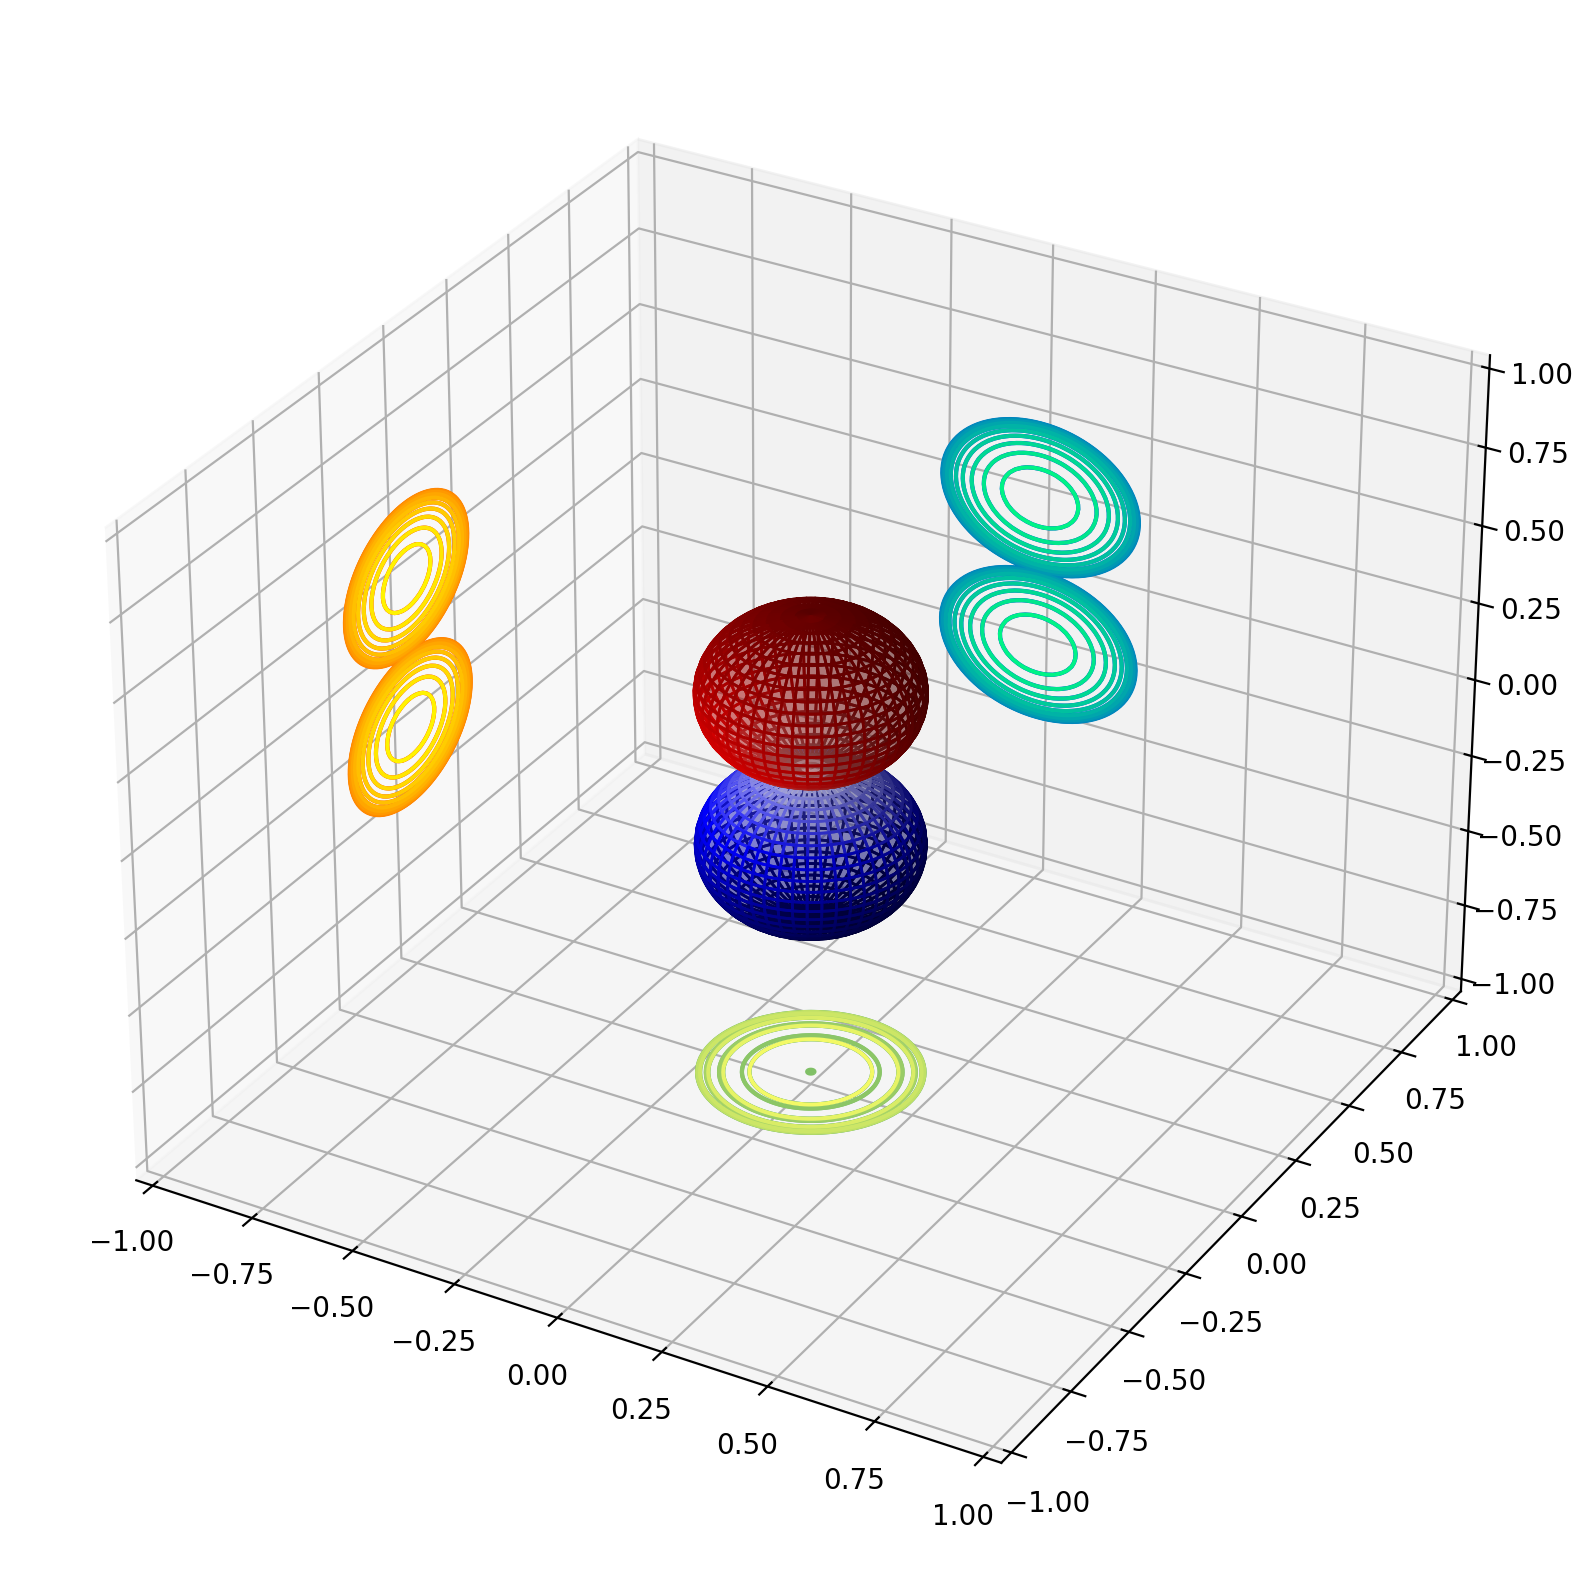

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

''' Normalize color bar to [0,1] scale'''
fcolors = (Ylm - Ylm.min())/(Ylm.max() - Ylm.min())

'''Make 3D plot of real part of spherical harmonic'''
ax.plot_surface(x, y, z, facecolors=cm.seismic(fcolors), alpha=0.3)


''' Project 3D plot onto 2D planes'''
cset = ax.contour(x, y, z,20, zdir='z',offset = -1, cmap='summer')
cset = ax.contour(x, y, z,20, zdir='y',offset =  1, cmap='winter' )
cset = ax.contour(x, y, z,20, zdir='x',offset = -1, cmap='autumn')


''' Set axes limit to keep aspect ratio 1:1:1 '''
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

#### 3. Describing the normalized probability as wavefunction squared $|\psi _{nlm}(r,\theta ,\varphi)|^2$ 

$$\psi_{nlm} = R_{nl}(r) \cdot Y_{l}^{m}(\theta, \varphi)$$

In [20]:
def normalized_wavefunction(n, 
                            l, 
                            m):

    '''Ψnlm(r,θ,φ) normalized wavefunction
    by definition of quantum numbers n, l, m and a bohr radius augmentation coefficient'''

    # Set coordinates grid to assign a certain probability to each point (x, y) in the plane
    x = y = np.linspace(-20, 20, 1000)
    x, y = np.meshgrid(x, y)
    r = np.sqrt((x ** 2 + y ** 2))

    # Ψnlm(r,θ,φ) = Rnl(r).Ylm(θ,φ)
    psi = radial_function(r, n, l) * angular_function(m, l, np.arctan(x / (y + 1e-10)), 0)

    return np.abs(psi) ** 2

#### 4. Plotting wavefunction electron probability density plots

In [21]:
def plot_wavefunction(n, 
                      l, 
                      m):

    fig, ax = plt.subplots()
    im = ax.imshow(np.sqrt(normalized_wavefunction(n, l, m)), cmap='rocket')

    # Add colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.09)
    cbar.set_ticks([])

    # Apply dark palette 
    fig.patch.set_facecolor('#020419'); cbar.outline.set_visible(False)
    plt.rcParams['text.color']='#dfdfdf'; ax.tick_params(axis='x', colors='#c4c4c4')
    ax.tick_params(axis='y', colors='#c4c4c4')

    ax.spines['top'].set_color('#020419'); ax.spines['right'].set_color('#020419')
    ax.spines['bottom'].set_color('#c4c4c4'); ax.spines['left'].set_color('#c4c4c4')
    ax.set_title(r'$\psi_{{({0}, {1}, {2})}}$'.format(n, l, m), pad=20, fontsize=15, color='#dfdfdf')

    # Add text and labels
    ax.invert_yaxis()

    # Save plot
    #plt.savefig(f'wavefunction ({n},{l},{m}).png', dpi=245, bbox_inches='tight', pad_inches=0.3)

###  Implementation | Output:

Light shaded areas in the orbital cross-sections represent a high probability of a particle being present in that region.

/tmp/ipykernel_11065/2304368228.py:12: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

/tmp/ipykernel_11065/381138519.py:10: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

/tmp/ipykernel_11065/381138519.py:11: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`



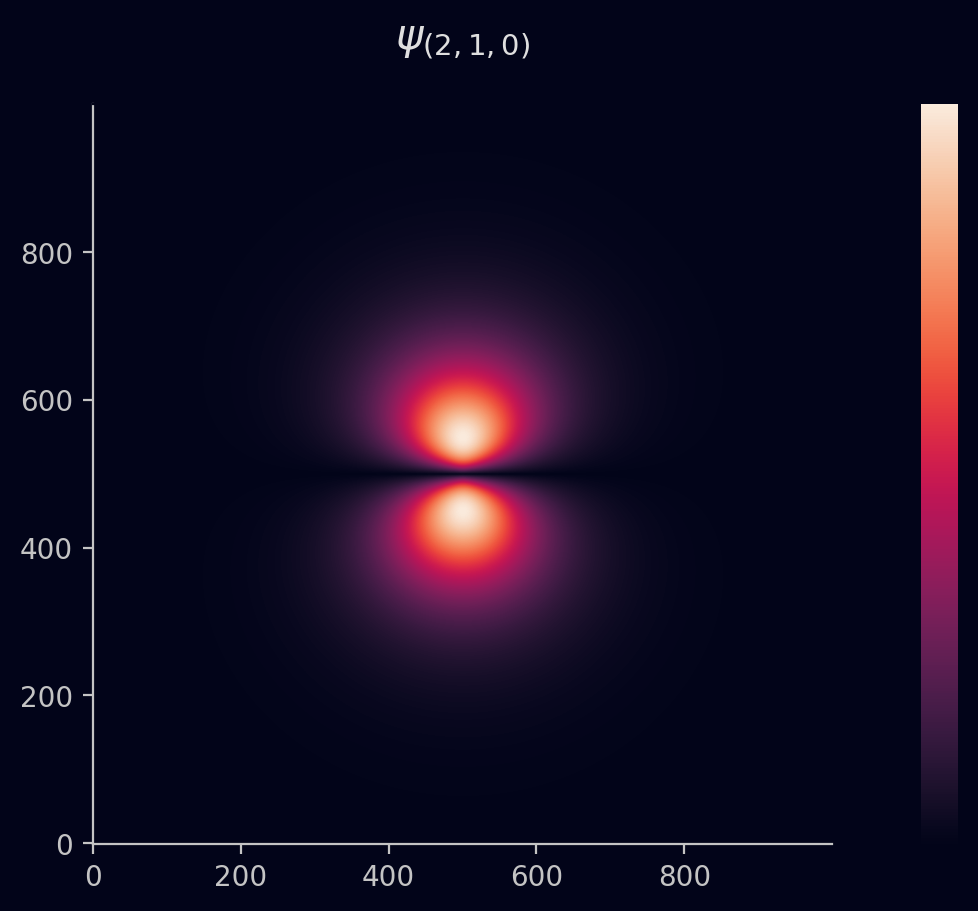

In [22]:
plot_wavefunction(n=2, 
                  l=1, 
                  m=0)  